In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

In [16]:
# Load engineered features
features_df = pd.read_csv("user_features.csv")

print(features_df.head())
print(features_df.info())

      user  total_logins  unique_days  after_hours  unique_machines  \
0  AAE0190            37           19            0                1   
1  AAF0535            37           19            0                1   
2  AAF0791            37           19            0                1   
3  AAL0706            37           19           19                1   
4  AAM0658            37           19           18                1   

   usb_count  usb_days          employee_name  user_id   O   C   E   A   N  
0        0.0       0.0   August Armando Evans  AAE0190  36  30  14  50  29  
1        0.0       0.0  Athena Amelia Foreman  AAF0535  17  21  36  33  31  
2        0.0       0.0  Aladdin Abraham Foley  AAF0791  14  40  40  50  34  
3        0.0       0.0       April Alika Levy  AAL0706  37  14  28  13  25  
4        0.0       0.0       Abel Adam Morton  AAM0658  43  35  37  36  22  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   

In [20]:
# Prepare data for modeling
print("Original columns:", features_df.columns.tolist())
print("Data types:")
print(features_df.dtypes)

# Drop common identifier/string columns first (so downstream selection is numeric-only)
drop_candidates = [c for c in ["user_id", "user", "employee_name", "employee"] if c in features_df.columns]
if drop_candidates:
    print("Dropping identifier columns:", drop_candidates)
features_clean = features_df.drop(columns=drop_candidates, errors="ignore")

# Select only numeric columns for modeling
numeric_columns = features_clean.select_dtypes(include=[np.number]).columns.tolist()
print(f"\nNumeric columns found: {numeric_columns}")

# Create feature matrix (only numeric columns)
X = features_clean[numeric_columns].copy()
print(f"Feature matrix shape: {X.shape}")

# Safety check: ensure no object columns remain
obj_cols = X.select_dtypes(include=['object']).columns.tolist()
if obj_cols:
    raise ValueError(f"Non-numeric columns still present in X: {obj_cols}")

# Scale the numeric data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Data successfully scaled!")
print(f"Scaled data shape: {X_scaled.shape}")

Original columns: ['user', 'total_logins', 'unique_days', 'after_hours', 'unique_machines', 'usb_count', 'usb_days', 'employee_name', 'user_id', 'O', 'C', 'E', 'A', 'N']
Data types:
user                object
total_logins         int64
unique_days          int64
after_hours          int64
unique_machines      int64
usb_count          float64
usb_days           float64
employee_name       object
user_id             object
O                    int64
C                    int64
E                    int64
A                    int64
N                    int64
dtype: object
Dropping identifier columns: ['user_id', 'user', 'employee_name']

Numeric columns found: ['total_logins', 'unique_days', 'after_hours', 'unique_machines', 'usb_count', 'usb_days', 'O', 'C', 'E', 'A', 'N']
Feature matrix shape: (1000, 11)
Data successfully scaled!
Scaled data shape: (1000, 11)


In [21]:
# Initialize model
iso_forest = IsolationForest(
    n_estimators=200,
    contamination=0.05,  # % of anomalies expected
    random_state=42
)

# Fit model
iso_forest.fit(X_scaled)

# Predict anomalies
features_df["anomaly_score"] = iso_forest.decision_function(X_scaled)
features_df["anomaly_label"] = iso_forest.predict(X_scaled)

# Convert labels: -1 = anomaly, 1 = normal
features_df["anomaly_label"] = features_df["anomaly_label"].map({1: 0, -1: 1})

In [22]:
features_df.to_csv("results/anomaly_scores_by_user.csv", index=False)

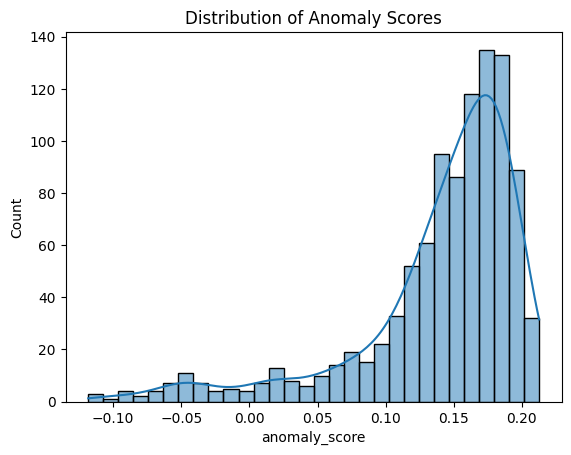

anomaly_label
0    950
1     50
Name: count, dtype: int64


In [23]:
sns.histplot(features_df["anomaly_score"], kde=True)
plt.title("Distribution of Anomaly Scores")
plt.show()

# Count anomalies vs normals
print(features_df["anomaly_label"].value_counts())


In [24]:
if "label" in features_df.columns:
    print(classification_report(features_df["label"], features_df["anomaly_label"]))
    print(confusion_matrix(features_df["label"], features_df["anomaly_label"]))

In [25]:
import joblib
joblib.dump(iso_forest, "models/isolation_forest.pkl")


['models/isolation_forest.pkl']

In [27]:
print("Available columns:", features_df.columns.tolist())


Available columns: ['user', 'total_logins', 'unique_days', 'after_hours', 'unique_machines', 'usb_count', 'usb_days', 'employee_name', 'user_id', 'O', 'C', 'E', 'A', 'N', 'anomaly_score', 'anomaly_label']


In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix


In [29]:
# 1. Set target
target_column = "anomaly_label"

y = features_df[target_column].astype(int).reset_index(drop=True)


In [30]:
# 2. Drop target + IDs from features
drop_cols = ["user", "employee_name", "user_id", "anomaly_label", "anomaly_score"]
X = features_df.drop(columns=drop_cols, errors="ignore")

# Keep only numeric features
X = X.select_dtypes(include=[np.number])

print("Final feature columns:", X.columns.tolist())

Final feature columns: ['total_logins', 'unique_days', 'after_hours', 'unique_machines', 'usb_count', 'usb_days', 'O', 'C', 'E', 'A', 'N']


In [31]:
# 3. Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled feature matrix:", X_scaled.shape)
print("Target vector:", y.shape)

Scaled feature matrix: (1000, 11)
Target vector: (1000,)


In [39]:
# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

In [40]:
# 5. Train Isolation Forest (or replace with other model)
model = IsolationForest(n_estimators=1000, contamination=0.05, random_state=42)
model.fit(X_train)

# Predict (convert -1 to 1, 1 to 0 to align with labels)
y_pred = model.predict(X_test)
y_pred = [1 if p == -1 else 0 for p in y_pred]

In [38]:
# 6. Evaluate
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[190   0]
 [  0  10]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       190
           1       1.00      1.00      1.00        10

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [1]:
import pandas as pd

insiders_df = pd.read_csv("insiders.csv")
print("Shape:", insiders_df.shape)
print("\nColumns:", insiders_df.columns.tolist())
print("\nSample data:")
print(insiders_df.head())

Shape: (191, 6)

Columns: ['dataset', 'scenario', 'details', 'user', 'start', 'end']

Sample data:
   dataset  scenario     details     user                start  \
0      2.0         1      r2.csv  ONS0995     3/6/2010 1:41:56   
1      3.1         1  r3.1-1.csv  CSF0929  07/01/2010 01:24:58   
2      3.1         2  r3.1-2.csv  CCH0959  08/02/2010 10:34:31   
3      3.2         1  r3.2-1.csv  RCW0822  09/29/2010 21:10:27   
4      3.2         2  r3.2-2.csv  JCE0258  07/12/2010 08:16:02   

                   end  
0    3/20/2010 8:10:12  
1  07/16/2010 06:52:00  
2  09/30/2010 15:04:03  
3  10/15/2010 06:34:52  
4  09/03/2010 16:16:29  


In [2]:
features_df = pd.read_csv("user_features.csv")
insiders_df = pd.read_csv("insiders.csv")
print(features_df.shape, insiders_df.shape)

(1000, 14) (191, 6)


In [3]:
features_df["user"] = features_df["user"].astype(str).str.strip().str.upper()
insiders_df["user"] = insiders_df["user"].astype(str).str.strip().str.upper()

In [ ]:
features_df["ground_truth"] = features_df["user"].isin(insiders_df["user"]).astype(int)
print(features_df["ground_truth"].value_counts())

ground_truth
0    930
1     70
Name: count, dtype: int64


In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import os

# Actual labels (from insider truth file)
y_true = features_df["ground_truth"].astype(int)

# Load saved predictions (results/anomaly_scores_by_user.csv) and align by user
res_path = os.path.join("results", "anomaly_scores_by_user.csv")
if not os.path.exists(res_path):
    raise FileNotFoundError(f"Results file not found at {res_path}")
res = pd.read_csv(res_path)

# Standardize user column if present
if 'user' in features_df.columns and 'user' in res.columns:
    left = features_df[['user']].copy()
    left['user'] = left['user'].astype(str).str.strip().str.upper()
    res['user'] = res['user'].astype(str).str.strip().str.upper()
    merged = left.merge(res, on='user', how='left')
else:
    # No user alignment possible — try to use order-preserving predictions
    merged = res.copy()

# Decide predicted labels: prefer anomaly_label column, else infer from anomaly_score using contamination
if 'anomaly_label' in merged.columns:
    y_pred = merged['anomaly_label'].fillna(0).astype(int)
elif 'anomaly_score' in merged.columns:
    # Anomaly score from IsolationForest: lower -> more anomalous
    scores = merged['anomaly_score'].astype(float)
    # default contamination fallback
    contamination = 0.05
    thresh = np.nanpercentile(scores.dropna(), 100 * contamination)
    # predict anomaly if score <= thresh (anomalies are low scores)
    y_pred = (scores <= thresh).astype(int).fillna(0)
else:
    raise KeyError('No anomaly_label or anomaly_score column found in results file.')

# If merged includes extra rows or alignment used, ensure lengths match by selecting same index as features_df
if 'user' in features_df.columns and 'user' in merged.columns:
    # merged length equals features_df
    pass
else:
    # If shapes mismatch, attempt to trim/pad
    if len(y_pred) != len(y_true):
        raise ValueError(f"Length mismatch after loading predictions: y_true={len(y_true)}, y_pred={len(y_pred)}. Ensure results file aligns with features_df or contains 'user' column for merging.")

# Print class distribution and diagnostics
print("Ground-truth counts:\n", y_true.value_counts())
print("Predicted counts:\n", pd.Series(y_pred).value_counts())

# Generate metrics
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=["Normal", "Insider"], zero_division=0)

print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", report)

Ground-truth counts:
 ground_truth
0    930
1     70
Name: count, dtype: int64
Predicted counts:
 anomaly_label
0    950
1     50
Name: count, dtype: int64

Confusion Matrix:
 [[892  38]
 [ 58  12]]

Classification Report:
               precision    recall  f1-score   support

      Normal       0.94      0.96      0.95       930
     Insider       0.24      0.17      0.20        70

    accuracy                           0.90      1000
   macro avg       0.59      0.57      0.57      1000
weighted avg       0.89      0.90      0.90      1000

